# Анализ данных в задаче кредитного скоринга

In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [4]:
data.default.value_counts() # соотношение возврата (0) и невозварата (1) долга

0    23364
1     6636
Name: default, dtype: int64

In [5]:
# разделим выборку по возврату долга
credit_return = data[data.default == 0] # возврат
credit_default = data[data.default == 1] # невозврат

In [6]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения ?

**a)** Построим гистограммы для определения критериев значимости (нормальные -> параметрические, скошенные -> непараметрические)

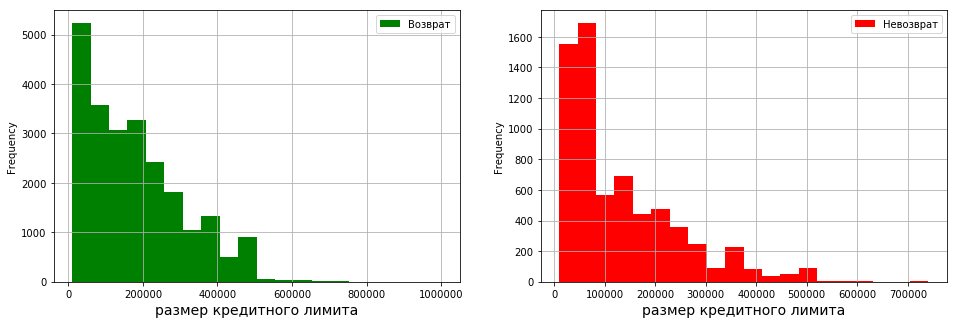

In [7]:
plt.figure(figsize(16,5))

plt.subplot(121)
credit_return['LIMIT_BAL'].plot.hist(bins = 20, color = 'g', label=u'Возврат')
plt.xlabel(u'размер кредитного лимита', fontsize=14)
pylab.grid()
pylab.legend()

plt.subplot(122)
credit_default['LIMIT_BAL'].plot.hist(bins = 20, color = 'r', label=u'Невозврат')
plt.xlabel(u'размер кредитного лимита', fontsize=14)
pylab.grid()
pylab.legend()

Распределения скошены, следовательно необходимо применять непараметрические критерии значимости. Визуально наблюдается некоторая схожесть данных распределений

In [8]:
# 95% Доверительный интервал для медианы на основе порядковых статистик (данный блок заимствован*)
#(http://www.machinelearning.ru/wiki/index.php?title=Интервальная_оценка)

def median_conf_int(sample):
    var_row = np.array(sample.sort_values()) # вариационный ряд
    n = var_row.shape[0]   
    k1 = int(floor(1./2.*(n-1.96*n**0.5-1.)))
    k2 = int(n-k1)
    return var_row[k1],var_row[k2]

In [9]:
print '95%% доверительный интервал для медианы по возврату долга: [%d, %d]' % median_conf_int(credit_return.LIMIT_BAL)
print '95%% доверительный интервал для медианы по невозврату долга: [%d, %d]' % median_conf_int(credit_default.LIMIT_BAL)

95% доверительный интервал для медианы по возврату долга: [150000, 150000]
95% доверительный интервал для медианы по невозврату долга: [80000, 90000]


Интервальные оценки не пересекаются, гипотеза о равенстве медианных значений отвергается в пользу альтернативы (медианы неравны)

Оценим интервальные оценки посредством бутстрепа

In [10]:
# функция генерации n_samples случайных псевдовыборок из выборки data такого же размера
def get_bootstrap_samples(data, n_samples): 
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

# оценка интервала на основе квантилей a/2 и (1-a)/2
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
np.random.seed(0)

# сгенерируем по 1000 случайных псевдовыборок
return_median_scores = map(np.median, get_bootstrap_samples(credit_return.LIMIT_BAL.values, 1000))
default_median_scores = map(np.median, get_bootstrap_samples(credit_default.LIMIT_BAL.values, 1000))

# на данных псевдовыборках посчитаем доверительные интервалы
print "95% доверительный интервал для медианы по возврату долга:", stat_intervals(return_median_scores, 0.05)
print "95% доверительный интервал для медианы по невозврату долга:", stat_intervals(default_median_scores, 0.05)

95% доверительный интервал для медианы по возврату долга: [ 150000.  150000.]
95% доверительный интервал для медианы по невозврату долга: [ 80000.  90000.]


Оценки по двум методам совпадают, можно оценить разность медиан (однако это уже лишнее)

In [12]:
# интервальная оценка разности медиан
delta_median_scores = map(lambda x,y: y-x, default_median_scores, return_median_scores)

print "95% доверительный интервал для разности медиан:",  stat_intervals(delta_median_scores, 0.05)

95% доверительный интервал для разности медиан: [ 60000.  70000.]


Ноль в интервал не попадает, нулевая гипотеза о равенстве медиан отвергается

**b)** По скошенности распределений мы определили, что необходимо применять непараметрические критерии, однаго Ранговый критерий Манна-Уитни нам не подходит, в силу ограничения количества повторяющихся значений (меньше 10):

https://ru.wikipedia.org/wiki/U-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9C%D0%B0%D0%BD%D0%BD%D0%B0_%E2%80%94_%D0%A3%D0%B8%D1%82%D0%BD%D0%B8

In [13]:
# покажем максимальное чилсо повторений для каждой повыборки (возврат и невозврат)
print credit_return.LIMIT_BAL.value_counts().max(), "и", credit_default.LIMIT_BAL.value_counts().max()

2480 и 885


Применим перестановочный критерий для независимых выборок для проверки равенства средних

In [14]:
# T-статистика (разность средних)
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [15]:
# случайные комбинации в случае ограничения на количество переборов (max_combinations)
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [16]:
# определение нулевого распределения посредсвтом перебора всех возмодных комбинаций 
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

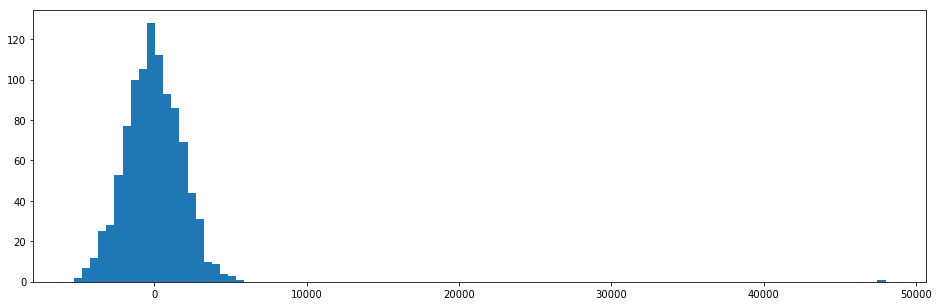

In [17]:
# нулевое распределение для критерия перестановок
pylab.hist(permutation_zero_dist_ind(credit_return.LIMIT_BAL, credit_default.LIMIT_BAL, max_combinations = 1000), bins = 100)
pylab.show()

In [18]:
# определение критерия значимости
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean) # T-статистика
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations) # нулевое распределение
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [19]:
print "p-value: %f" % permutation_test(credit_return.LIMIT_BAL, credit_default.LIMIT_BAL, max_permutations = 100)

p-value: 0.010000


In [20]:
print "p-value: %f" % permutation_test(credit_return.LIMIT_BAL, credit_default.LIMIT_BAL, max_permutations = 1000)

p-value: 0.001000


Нулевая гипотеза о равенстве распределений отвергается в пользу альтернативы (распределения кредитных лимитов различны). Результаты значимы согласно логике: модель должна быть построена таким образом, чтобы минимизировать потери в случае невозврата долга, следовательно более потенциальным неплательщикам следует сократить кредитный лимит, так медианы кредитного лимита для двух подргуп и отличаются почти вдове.

### Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

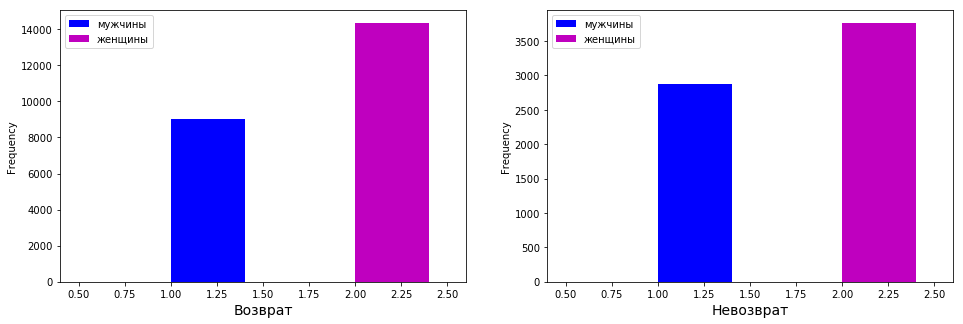

In [21]:
plt.figure(figsize(16,5))

plt.subplot(121)
credit_return['SEX'][credit_return['SEX']==1].plot.hist(color = 'b', label=u'мужчины', width=0.4)
credit_return['SEX'][credit_return['SEX']==2].plot.hist(color = 'm', label=u'женщины', width=0.4)
plt.xlabel(u'Возврат', fontsize=14)
pylab.legend()

plt.subplot(122)
credit_default['SEX'][credit_default['SEX']==1].plot.hist(color = 'b', label=u'мужчины', width=0.4)
credit_default['SEX'][credit_default['SEX']==2].plot.hist(color = 'm', label=u'женщины', width=0.4)
plt.xlabel(u'Невозврат', fontsize=14)
pylab.legend()

Визуально, распределения почти схожи

In [22]:
# создадим массивы из значений наших подвыборок перейдя к новым обозначениям 0-М, 1-Ж (просто вычитая из значений 1)
credit_return_sex = np.array(credit_return['SEX'])-1
credit_default_sex = np.array(credit_default['SEX'])-1

Интервальные оценки долей

In [23]:
conf_interval_return = proportion_confint(sum(credit_return_sex), credit_return_sex.shape[0], method = 'wilson')
conf_interval_default = proportion_confint(sum(credit_default_sex), credit_default_sex.shape[0], method = 'wilson')

In [24]:
print '95%% доверительный интервал для возврата долга по гендеру: [%f, %f]' % conf_interval_return
print '95%% доверительный интервал для невозврата долга по гендеру: [%f, %f]' % conf_interval_default

95% доверительный интервал для возврата долга по гендеру: [0.607890, 0.620373]
95% доверительный интервал для невозврата долга по гендеру: [0.555102, 0.578938]


Доверительные интервалы не пересекаются, следовательно нулевая гипотеза о схожести гендерных групп отвергается в пользу альтернативы (генредные состав относительно возварат и невозварата долга отличается)

Определим интервал для разности долей:

In [25]:
# Довертильеный интервал
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [26]:
# Z статистика
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
# Расчет P-value по полученной Z-статистики и вида альернативы (двухсторонняя) на основе функции распределения
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [28]:
print "95%% доверительный интервал для разности долей: [%f, %f]" %\
      proportions_diff_confint_ind(credit_return_sex, credit_default_sex)

95% доверительный интервал для разности долей: [0.033635, 0.060548]


Отметим, что ноль не попадает в интервал, это говорит в пользу альтернативы, против нулевой гипотезы

Посчитаем уровень значимости:

In [29]:
print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(credit_return_sex, credit_default_sex))

p-value: 0.000000


Значение p-value мало относительно порога альфа. Это и все выше сказанное говорит об одном: нулевая гипотеза о равенстве гендорного состава относительно возврата долга с уверенностью отвергается, в пользу двухсторонней альтернативы (гендерный состав людей вернувших и не вернувших долг отличается)

### Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

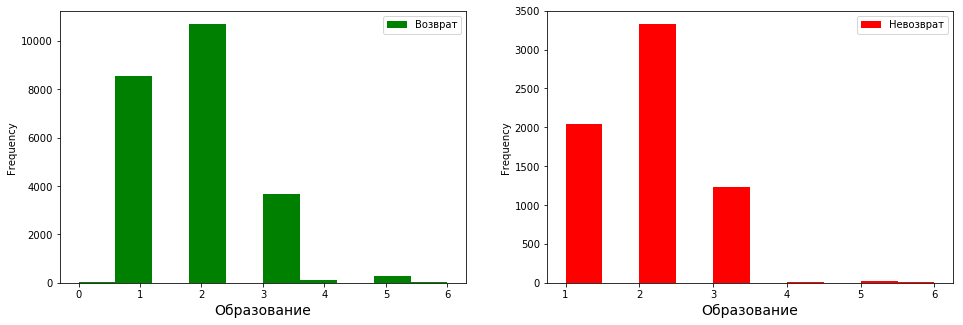

In [30]:
plt.figure(figsize(16,5))

plt.subplot(121)
credit_return['EDUCATION'].plot.hist(color = 'g', label=u'Возврат')
plt.xlabel(u'Образование', fontsize=14)
pylab.legend()

plt.subplot(122)
credit_default['EDUCATION'].plot.hist(color = 'r', label=u'Невозврат')
plt.xlabel(u'Образование', fontsize=14)
pylab.legend()

Построение сводной таблицы количества людей в зависимости от образования и возврата/невозварата долга

In [32]:
count_education = pd.pivot_table(data, values='ID', index=['EDUCATION'],
                    columns=['default'], aggfunc='count', fill_value = 0)

In [33]:
count_education

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Определим коэффициент V Крамера (корреляция для категориальных признаков)

In [34]:
# фкнция Фи (Коэффициент Крамера) (стр 6,10 лекция Корреляция урок 8)
def Cramer(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0] # определим хи-квадрат для сводной таблицы
    n = sum(count_education.sum()) # сумма по элементам выборки
    Min_K = min(count_education.shape) # минимум между числом строк и столбцов в таблице сопряженности

    return np.sqrt( chi2 / (n*(Min_K-1)) )

In [35]:
print "Коэффициент V Крамера: %f" % Cramer(np.array(count_education))

Коэффициент V Крамера: 0.073760


In [36]:
# Статистика хи-квадрат
chi2, p, dof, ex = scipy.stats.chi2_contingency(count_education)
print "P: %f" % p

P: 0.000000


Построим таблицу разности между ожидаемыми (ex-определили по хи-квадрат) и наблюдаемыми значениями (из сводной таблицы)

In [37]:
(count_education-ex) # просто вычтем из таблицы ожидаемые значения статистики хи-квадрат (ex)

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


* Коэффициент V Крамера составляет порядка 7%, в данном случае трудно говорить о явной взаимосвязи двух признаков (образование и возврат кредита)


* Однако, посредством критерия хи-квадрат, нулевая гипотеза о равенстве нулю коэффициента V Крамера (независимости двух признаков) отвергается в пользу альтернативы (**существует взаимосвязь между образованием и возвратом кредита**)


* Исходя из графика и таблицы разности ожидаемых и наблюдаемых значений, можно предположить что наличие магистратуры является наилучшим индикатором того, что человек отдаст долг, а начличие степени бакалавра наоборт, говорит о более высокой вероятности не вернуть кредит.

### Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

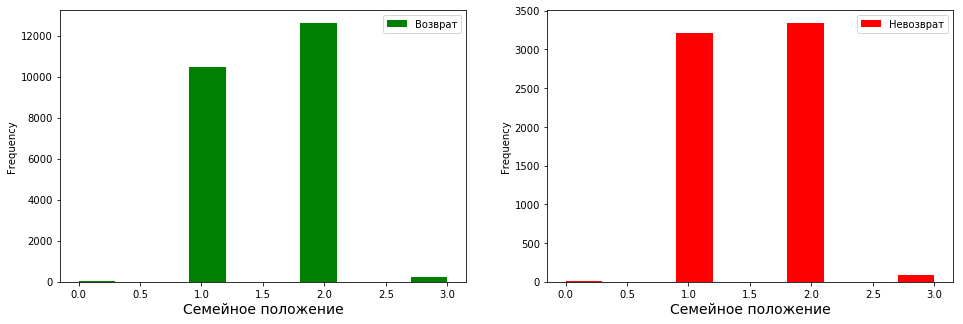

In [38]:
plt.figure(figsize(16,5))

plt.subplot(121)
credit_return['MARRIAGE'].plot.hist(color = 'g', label=u'Возврат')
plt.xlabel(u'Семейное положение', fontsize=14)
pylab.legend()

plt.subplot(122)
credit_default['MARRIAGE'].plot.hist(color = 'r', label=u'Невозврат')
plt.xlabel(u'Семейное положение', fontsize=14)
pylab.legend()

Корреляцию V Крамера применить не получится, в силу двух причин: 1) два значения в признаке: 0 и 3, не дают особо полезной информации, так в первом случае человек отказывался отвечать на вопрос, а во втором - данных попросту нет.  2) малость этих двух значений признака, по сравнению с двумя другими: 1 и 2.

А вот если избавиться от них, то можно применить корреляцию Метьюса для двух бинарных признаков: Семейное положение и Возврат/невозврат долга

In [39]:
# сгенерируем данные бинарные подвыборки для признака Семейное положение (MARRIAGE) выкинув значение 0 и 3
credit_return_marriage = credit_return.MARRIAGE[credit_return.MARRIAGE.isin([0,3])==False]
credit_default_marriage = credit_default.MARRIAGE[credit_default.MARRIAGE.isin([0,3])==False]

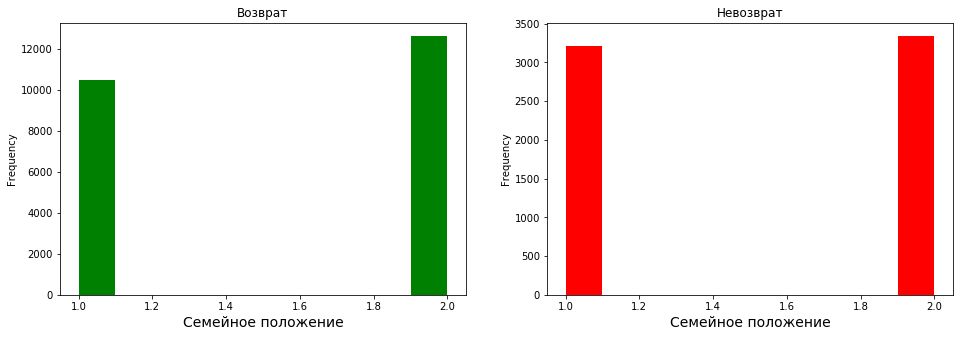

In [72]:
plt.figure(figsize(16,5))

plt.subplot(121)
credit_return_marriage.plot.hist(color = 'g')
plt.title(u'Возврат')
plt.xlabel(u'Семейное положение', fontsize=14)

plt.subplot(122)
credit_default_marriage.plot.hist(color = 'r')
plt.title(u'Невозврат')
plt.xlabel(u'Семейное положение', fontsize=14)

In [73]:
# преобразуем признак в бинарный (вычтем из значений 1, получим значения 0 и 1)
# перейдем к количеством значений для 0 и 1 и выведим это списком
b, a = list((credit_return_marriage-1).value_counts()) # единицы и нули для default=0
d, c = list((credit_default_marriage-1).value_counts()) # единицы и нули для default=1

In [74]:
# корреляция Мэтьюса
mcc = float(a*d-b*c)/(float(a+b)*(a+c)*(b+d)*(c+d))**0.5
print "Коэффициент корреляции Мэтьюса, mcc: %f" % mcc

Коэффициент корреляции Мэтьюса, mcc: -0.030555


In [69]:
# Статистика Хи-квадрат
stats.chi2_contingency([[a,b],[c,d]])

(27.509409092957899,
 1.5633210355976673e-07,
 1,
 array([[ 10640.21483307,  12435.78516693],
        [  3018.78516693,   3528.21483307]]))

2    12623
1    10453
Name: MARRIAGE, dtype: int64

In [83]:
((b+d)*(c+d))/float(a+b+c+d)

3528.2148330688992

Коэффицент корреляции Мэтьюса говорит нам об отсутствии связи (-3%), однако критерий хи-квадрат значительно меньше уровня значимости 0.05, что позволяет отвергнуть нулевую гипотезу об отсутствии связи между семейным положением и возвратом кредита в пользу альтернативы: **признаки "Семейное положение" и "Возврат долга" имеют взаимозависимость** наличие брака немного негативно сказывается на возврате кредита (возврат-0, брак-0: при отрицательной корреляции минимизируются пары 0,0 и 1,1)

### Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

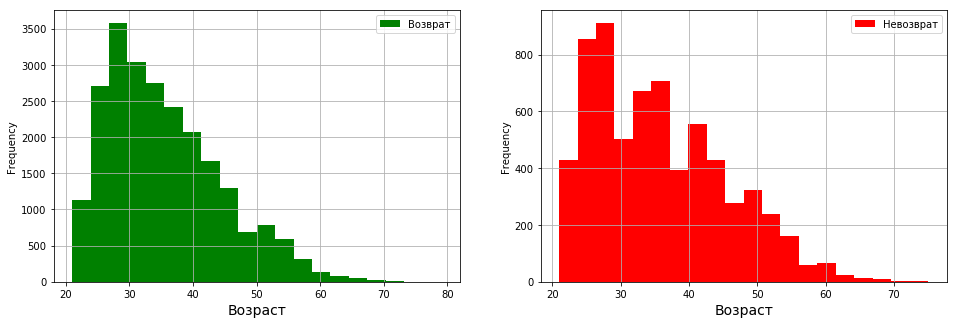

In [85]:
plt.figure(figsize(16,5))

plt.subplot(121)
credit_return['AGE'].plot.hist(bins = 20, color = 'g', label=u'Возврат')
plt.xlabel(u'Возраст', fontsize=14)
pylab.grid()
pylab.legend()

plt.subplot(122)
credit_default['AGE'].plot.hist(bins = 20, color = 'r', label=u'Невозврат')
plt.xlabel(u'Возраст', fontsize=14)
pylab.grid()
pylab.legend()

а) Проверка равенства медианных значений возрастов людей

In [86]:
#Доверительный интервал на основе порядковых статистик
print '95%% доверительный интервал для медианы возраста (возврат): [%d, %d]' % median_conf_int(credit_return.AGE)
print '95%% доверительный интервал для медианы возраста (невозврат): [%d, %d]' % median_conf_int(credit_default.AGE)

95% доверительный интервал для медианы возраста (возврат): [34, 34]
95% доверительный интервал для медианы возраста (невозврат): [34, 35]


In [87]:
#Бутстреп
np.random.seed(0)

# сгенерируем по 1000 случайных псевдовыборок
return_median_scores = map(np.median, get_bootstrap_samples(credit_return.AGE.values, 1000))
default_median_scores = map(np.median, get_bootstrap_samples(credit_default.AGE.values, 1000))

# на данных псевдовыборках посчитаем доверительные интервалы
print "95% доверительный интервал для медианы по возврату долга:", stat_intervals(return_median_scores, 0.05)
print "95% доверительный интервал для медианы по невозврату долга:", stat_intervals(default_median_scores, 0.05)

95% доверительный интервал для медианы по возврату долга: [ 34.  34.]
95% доверительный интервал для медианы по невозврату долга: [ 34.  35.]


Интервальные оценки, посчитанные разными методами одинаковы и они пересекаются. Проверим интервальную разность медиан.

In [88]:
# интервальная оценка разности медиан
delta_median_scores = map(lambda x,y: y-x, default_median_scores, return_median_scores)

print "95% доверительный интервал для разности медиан:",  stat_intervals(delta_median_scores, 0.05)

95% доверительный интервал для разности медиан: [-1.  0.]


Ноль включен в интервал, т.о. в силу всего вышесказанное нулевая гипотеза о равенстве медианных значений не отвергается

b) Проверка равенства распределений с помощью критерия Перестановок (аналогично, как и в прошлый раз ранговые критерии неприменимы)

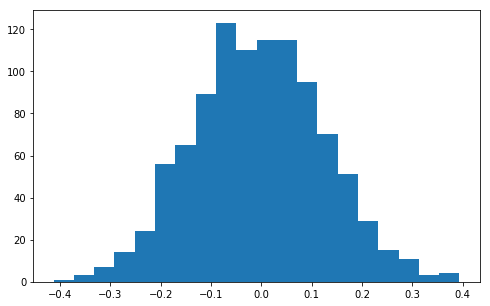

In [90]:
# нулевое распределение для критерия перестановок
plt.figure(figsize(8,5))
pylab.hist(permutation_zero_dist_ind(credit_return.AGE, credit_default.AGE, max_combinations = 1000), bins = 20)
pylab.show()

In [91]:
print "p-value: %f" % permutation_test(credit_return.AGE, credit_default.AGE, max_permutations = 1000)

p-value: 0.017000


Значение p-value ниже порога свидетельствует об опровержении гипотезы о равенстве распределений выборок возрастов клиентов с возвращенными и дефолтными кредитами. Однако оценка равенства медиан говорит об обратно (значения интервальных оценок пересекаются).

С практической точки зрения это объясняется следующим образом: возраст оказывает несущественное влияние на возварт долга, несмотря на различие распределений данных подвыборок. Это характеризуется тем, что кредиты выдаются предпочтительно молодым, в силу чего выравниваются медианные значения возраста в обеих подгруппах.